# 1. Рассмотрим текущие данные

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_absolute_error,r2_score

## 1.1 Файл `assessment`

In [2]:
# df_assessment = pd.read_csv('../data/assessment.csv',sep=';', low_memory=False)#dtype=dtype_assessment)
# print(df_assessment.columns)
# for item in df_assessment.columns:
#     print(f'"{item}": ,')

In [3]:
# converter для перевода нечитаемые строки в None
def my_int_converter(val):
    if isinstance(val, (int,float)):
        return val
    if isinstance(val,str):
        try:
            return float(val)
        except:
            return np.NaN
    return np.NaN


def my_ts_converter(val):
    if len(val) in (10,13):                
        try:
            val = int(val)
            if val>10**11:
                val = int(val/1000)                            
            return datetime.fromtimestamp(val)
        except:
            return np.NaN
    return np.NaN    


def my_date_converter(val):
    try:
        return datetime.strptime(val,'%d.%m.%Y %H:%M')
    except:
        return np.NaN     

In [4]:
# cols = ['id', 'user_id', 'course_id', 'start', 'finish', 'result', 'status',
#        'group_id', 'last_update', 'partner_campaign_id', 'finish_for_dod',
#        'mark', 'user_session_id', 'utm', 'lead_id', 'visible_mark',
#        'parent_id', 'force_amnesty']
int_cols = ['id', 'user_id', 'course_id', 'result', 'group_id', 'partner_campaign_id', 'user_session_id', \
    'lead_id','parent_id', 'force_amnesty']
date_cols = ['start', 'finish','finish_for_dod']
converters_assessment = {item:my_int_converter  for item in int_cols}
converters_assessment.update({ 'last_update':my_ts_converter})
converters_assessment.update({item:my_date_converter  for item in date_cols})    
# print(*converters_assessment.items(), sep='\n')

In [5]:
# df_assessment = pd.read_csv('../data/assessment.csv',sep=';', low_memory=False)#dtype=dtype_assessment)
df_assessment = pd.read_csv('../data/assessment.csv', sep=';',converters=converters_assessment)
#df_assessment[int_cols]=df_assessment[int_cols].astype((pd.Int64Dtype()))

In [6]:
df_assessment.head()

,id,user_id,course_id,start,finish,result,status,group_id,last_update,partner_campaign_id,finish_for_dod,mark,user_session_id,utm,lead_id,visible_mark,parent_id,force_amnesty
0,44.0,55.0,1.0,2016-02-01 00:14:00,2016-02-01 00:25:00,10.0,OK,1.0,NaT,NaN,2016-02-01 00:25:00,B,NaN,NaN,NaN,D,NaN,0.0
1,50.0,31.0,1.0,2016-02-02 13:28:00,2016-02-02 13:38:00,10.0,OK,1.0,NaT,NaN,2016-02-02 13:38:00,B,NaN,NaN,NaN,D,NaN,0.0
2,51.0,66.0,1.0,2016-02-03 17:09:00,2016-02-03 17:26:00,8.0,OK,1.0,NaT,NaN,2016-02-03 17:26:00,B,NaN,NaN,NaN,D,NaN,0.0
3,61.0,72.0,1.0,2016-02-04 21:39:00,2016-02-04 22:09:00,8.0,OK,1.0,NaT,NaN,2016-02-04 22:09:00,B,NaN,NaN,NaN,D,NaN,0.0
4,62.0,79.0,1.0,2016-02-05 08:28:00,2016-02-05 08:58:00,8.0,OK,1.0,NaT,NaN,2016-02-05 08:58:00,B,NaN,NaN,NaN,D,NaN,0.0


In [7]:
df_assessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86044 entries, 0 to 86043
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   86038 non-null  float64       
 1   user_id              86040 non-null  float64       
 2   course_id            86038 non-null  float64       
 3   start                86020 non-null  datetime64[ns]
 4   finish               70181 non-null  datetime64[ns]
 5   result               86041 non-null  float64       
 6   status               86044 non-null  object        
 7   group_id             76281 non-null  float64       
 8   last_update          61621 non-null  datetime64[ns]
 9   partner_campaign_id  12509 non-null  float64       
 10  finish_for_dod       70148 non-null  datetime64[ns]
 11  mark                 81754 non-null  object        
 12  user_session_id      71116 non-null  float64       
 13  utm                  55294 non-

In [8]:
df_assessment.head()

,id,user_id,course_id,start,finish,result,status,group_id,last_update,partner_campaign_id,finish_for_dod,mark,user_session_id,utm,lead_id,visible_mark,parent_id,force_amnesty
0,44.0,55.0,1.0,2016-02-01 00:14:00,2016-02-01 00:25:00,10.0,OK,1.0,NaT,NaN,2016-02-01 00:25:00,B,NaN,NaN,NaN,D,NaN,0.0
1,50.0,31.0,1.0,2016-02-02 13:28:00,2016-02-02 13:38:00,10.0,OK,1.0,NaT,NaN,2016-02-02 13:38:00,B,NaN,NaN,NaN,D,NaN,0.0
2,51.0,66.0,1.0,2016-02-03 17:09:00,2016-02-03 17:26:00,8.0,OK,1.0,NaT,NaN,2016-02-03 17:26:00,B,NaN,NaN,NaN,D,NaN,0.0
3,61.0,72.0,1.0,2016-02-04 21:39:00,2016-02-04 22:09:00,8.0,OK,1.0,NaT,NaN,2016-02-04 22:09:00,B,NaN,NaN,NaN,D,NaN,0.0
4,62.0,79.0,1.0,2016-02-05 08:28:00,2016-02-05 08:58:00,8.0,OK,1.0,NaT,NaN,2016-02-05 08:58:00,B,NaN,NaN,NaN,D,NaN,0.0


## 1.2 Файл `course`

In [9]:
# df_course[df_course['start_date']=='2050-01-01']

In [10]:
int_cols = ['id', 'salary', 'enabled', 'assessment_duration', 'assessment_min', 'program', \
      'visible', 'order_id', 'assessment_enabled', 'popularity', 'assessment_test_id','main_hide', \
      'main_show', 'blog_id','pzg_show', 'sql_query_id', 'is_partner', 'is_administrative', \
      'partner_project_id', 'send_bitrix_bad_assessment', 'is_success_experiment', 'landing_config_id', \
      'is_specialization', 'program_download_auth_require']
date_cols = ['start_date', 'slack_link_end', 'created_date']
converters_course  = {item:my_int_converter  for item in int_cols}
converters_course.update({item:my_date_converter  for item in date_cols})    

In [11]:
df_course = pd.read_csv('../data/course.csv', sep=';',converters=converters_course)
#df_course[int_cols]=df_course[int_cols].astype((pd.Int64Dtype()))
df_course.head()

,id,title,salary,enabled,description,icon,assessment_duration,shortname,assessment_min,short_description,...,offer_text,is_specialization,ga_goal_assessment_fail,ga_goal_assessment_start,ga_goal_assessment_success,block_background,program_download_auth_require,icon_bg_webp,icon_fg_webp,icon_scale_webp
0,1.0,Разработчик Java,160000.0,1.0,Вы получите <b>практику</b> решения сложных за...,d7/19/d71915b397a94461827988c04e4e9950.png,30.0,Java,8.0,На курсе изучаются особенности языка и платфор...,...,NaN,0.0,test_fail_java,NaN,test_ok_java,NaN,0.0,83/2c/832c14753f7944b2b3d2e9ac798222d9.WEBP,NaN,NaN
1,2.0,Разработчик Android (deprecated),140000.0,0.0,Длинное-длинное-длинное описание профессии And...,NaN,30.0,Android,2.0,Короткое описание профессии Android,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,3.0,Разработчик Python. Продвинутый курс,130000.0,1.0,"<b>Профессиональный онлайн-курс для тех, кто у...",42/32/4232b5002b754525b40e5bc132af26cc.png,30.0,Python,6.0,Python является языком общего назначения и чащ...,...,NaN,0.0,test_fail_python,NaN,test_ok_python,NaN,0.0,7a/b6/7ab6043095b545c2aae73b3d1c14b219.WEBP,NaN,NaN
3,4.0,Разработчик Ruby,130000.0,0.0,Длинное-длинное-длинное описание профессии Ruby,ruby,30.0,Ruby,2.0,Короткое описание профессии Ruby,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,5.0,Разработчик C++,150000.0,1.0,<ul>\r\n<li>Умение писать на С++ правильно.</l...,f1/75/f175c202c2c545c8b511d154e20b2def.png,30.0,C++,8.0,Являясь одним из самых популярных языков прогр...,...,NaN,0.0,test_fail_cplus,NaN,test_ok_cplus,NaN,0.0,52/48/5248695ac8a94232a50789ad162b5f00.WEBP,NaN,NaN


In [12]:
df_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 99 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             190 non-null    float64
 1   title                          190 non-null    object 
 2   salary                         19 non-null     float64
 3   enabled                        29 non-null     float64
 4   description                    126 non-null    object 
 5   icon                           112 non-null    object 
 6   assessment_duration            68 non-null     float64
 7   shortname                      13 non-null     object 
 8   assessment_min                 68 non-null     float64
 9   short_description              12 non-null     object 
 10  program                        0 non-null      float64
 11  start_date                     0 non-null      float64
 12  visible                        190 non-null    flo

## 1.3 Файл `invoice`

In [13]:
int_cols = [ 'id', 'user_id', 'amount', 'full_paid', 'month', 'partner_campaign_id', \
       'course_id', 'is_test', 'group_id', 'is_b2b', 'is_hidden', 'epn_reject_sended']
float_cols = ['discount']
date_cols = ['time','time_pay']
str_cols = ['return_check_id', 'return_check_status']
converters_invoice  = {item:my_int_converter  for item in int_cols+float_cols}
converters_invoice.update({item:my_date_converter  for item in date_cols})   
converters_invoice.update({item:str  for item in str_cols})   

In [14]:
df_invoice = pd.read_csv('../data/invoice.csv', sep=';', converters=converters_invoice)
#df_invoice[int_cols]=df_invoice[int_cols].astype((pd.Int64Dtype()))
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36348 entries, 0 to 36347
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   36343 non-null  float64       
 1   user_id              36345 non-null  float64       
 2   amount               36347 non-null  float64       
 3   status               36348 non-null  object        
 4   time                 36342 non-null  datetime64[ns]
 5   time_pay             22473 non-null  datetime64[ns]
 6   full_paid            36347 non-null  float64       
 7   month                21678 non-null  float64       
 8   utm                  28906 non-null  object        
 9   reason               35533 non-null  object        
 10  discount             36347 non-null  float64       
 11  partner_campaign_id  1627 non-null   float64       
 12  course_id            21554 non-null  float64       
 13  is_test              36348 non-

In [15]:
df_invoice.describe()

,id,user_id,amount,time,time_pay,full_paid,month,discount,partner_campaign_id,course_id,is_test,group_id,is_b2b,is_hidden,epn_reject_sended
count,36343.000000,36345.000000,36347.000000,36342,22473,36347.000000,21678.000000,36347.000000,1627.000000,21554.000000,36348.000000,19938.000000,36345.000000,36348.000000,36348.000000
mean,18227.685882,57972.795845,20834.255234,2019-09-03 01:31:52.478124544,2019-10-10 13:36:10.537978880,0.698104,1.479795,7857.728946,46.748002,42.018326,0.007346,214.699519,0.028284,0.000715,0.002118
min,1.000000,4.000000,0.000000,2016-01-27 18:51:00,2016-02-09 10:13:00,0.000000,0.000000,-3000.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,9127.500000,19445.000000,1.000000,2019-03-28 14:06:30,2019-06-12 14:54:00,0.000000,1.000000,0.000000,19.000000,7.000000,0.000000,93.000000,0.000000,0.000000,0.000000
50%,18242.000000,55451.000000,11240.000000,2020-01-27 16:48:00,2020-03-22 09:10:00,1.000000,1.000000,6000.000000,29.000000,25.000000,0.000000,195.000000,0.000000,0.000000,0.000000
75%,27330.500000,101265.000000,40000.000000,2020-04-11 17:04:15,2020-04-16 10:03:00,1.000000,1.000000,14999.000000,50.000000,74.000000,0.000000,304.000000,0.000000,0.000000,0.000000
max,36417.000000,128483.000000,840000.000000,2020-07-08 13:48:00,2020-07-08 13:17:00,1.000000,6.000000,108000.000000,286.000000,190.000000,1.000000,629.000000,1.000000,1.000000,1.000000
std,10510.515790,40363.113777,27731.906829,NaN,NaN,0.459087,1.030348,8263.657313,49.216473,42.716107,0.085393,138.900142,0.165787,0.026736,0.045978


In [16]:
# print(*df_invoice['full_paid'].unique(),sep='\n')
df_invoice['full_paid'].value_counts()

full_paid
1.0    25374
0.0    10973
Name: count, dtype: int64

In [17]:
df_invoice['full_paid'].isna()

0        False
1        False
2        False
3        False
4        False
         ...  
36343    False
36344    False
36345    False
36346    False
36347    False
Name: full_paid, Length: 36348, dtype: bool

## 1.4 Файл `lessons_homeworks`

In [18]:
# df_lessons_homeworks = pd.read_csv('../data/lessons_homeworkuser.csv',sep=';',low_memory=False)
# print(df_lessons_homeworks.columns)

In [19]:
int_cols = [ 'id', 'points', 'homework_id', 'user_id', 'assignee_id', 'is_was_revoked']
date_cols = ['status_update_time','last_message_time','first_attempt_time']
str_cols = ['comment']
converters_hl  = {item:my_int_converter  for item in int_cols}
converters_hl.update({item:my_date_converter  for item in date_cols})   
converters_hl.update({item:str  for item in str_cols})

In [20]:
# print(*df_lessons_homeworks['project_theme_status'].unique(),sep='\n')

In [21]:
df_lessons_homeworks = pd.read_csv('../data/lessons_homeworkuser.csv',sep=';', converters=converters_hl)
#df_lessons_homeworks[int_cols]=df_lessons_homeworks[int_cols].astype((pd.Int64Dtype()))
df_lessons_homeworks.describe()

,id,points,homework_id,user_id,assignee_id,status_update_time,last_message_time,first_attempt_time,is_was_revoked
count,74971.000000,74976.000000,74971.000000,74969.000000,52511.000000,74954,43738,38347,74977.000000
mean,37867.779328,7.703679,3765.066106,43514.688831,301.451296,2019-08-15 03:32:57.246310912,2019-08-07 15:07:19.004984320,2019-09-29 09:49:11.077789952,0.164744
min,1.000000,0.000000,1.000000,8.000000,1.000000,2018-02-27 04:30:00,2017-11-28 19:17:00,2018-06-04 19:07:00,0.000000
25%,19124.500000,0.000000,2065.000000,17357.000000,67.000000,2019-03-01 18:18:45,2019-02-15 04:40:00,2019-05-13 15:45:30,0.000000
50%,37880.000000,3.000000,3870.000000,39729.000000,214.000000,2019-09-29 12:41:00,2019-10-06 11:42:00,2019-11-11 11:55:00,0.000000
75%,56680.500000,5.000000,5430.000000,66919.000000,491.000000,2020-03-17 14:42:00,2020-03-21 04:24:00,2020-03-26 18:10:30,0.000000
max,75458.000000,100.000000,8185.000000,128252.000000,1299.000000,2020-07-08 14:27:00,2020-07-08 14:27:00,2020-07-08 13:50:00,1.000000
std,21722.925123,19.618750,2026.970956,30378.381760,290.743778,NaN,NaN,NaN,0.370952


In [22]:
df_lessons_homeworks.head()

,id,points,comment,homework_id,user_id,assignee_id,status,status_update_time,last_message_time,first_attempt_time,is_was_revoked,project_theme,project_theme_status
0,1.0,0.0,,20.0,5950.0,16.0,new,2018-02-27 04:30:00,NaT,NaT,0.0,NaN,new
1,2.0,10.0,,1.0,5983.0,22.0,accept,2018-02-27 04:30:00,2017-11-28 19:17:00,NaT,0.0,NaN,new
2,3.0,12.0,,2.0,3189.0,22.0,accept,2018-02-27 04:30:00,NaT,NaT,0.0,NaN,new
3,4.0,14.0,,1.0,3189.0,22.0,accept,2018-02-27 04:30:00,NaT,NaT,0.0,NaN,new
4,5.0,8.0,,1.0,800.0,22.0,accept,2018-02-27 04:30:00,NaT,NaT,0.0,NaN,new


In [23]:
df_lessons_homeworks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74980 entries, 0 to 74979
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    74971 non-null  float64       
 1   points                74976 non-null  float64       
 2   comment               74980 non-null  object        
 3   homework_id           74971 non-null  float64       
 4   user_id               74969 non-null  float64       
 5   assignee_id           52511 non-null  float64       
 6   status                74978 non-null  object        
 7   status_update_time    74954 non-null  datetime64[ns]
 8   last_message_time     43738 non-null  datetime64[ns]
 9   first_attempt_time    38347 non-null  datetime64[ns]
 10  is_was_revoked        74977 non-null  float64       
 11  project_theme         677 non-null    object        
 12  project_theme_status  74978 non-null  object        
dtypes: datetime64[ns

## 1.5 Файл `user_course`

In [24]:
# df_user_course = pd.read_csv('../data/user_course.csv',sep=';',low_memory=False)
# print(df_user_course.columns)

In [25]:
int_cols = [ 'user_id', 'course_id', 'paid',  'full_paid', 'money_used', \
       'month_used', 'id', 'group_id',  'promocode_id', 'paid_month', \
        'mark', 'overdraft', 'reason_id','force_full_pay_flag', \
       'assessment_reused', 'show_mark', 'partner_campaign_id', \
       'company_id', \
       'assessment_id', 'is_hidden', 'loyalty_applied', \
       'welcome_applied', 'useronlinecourse_applied_id', 'tax_deduction_pdf_size', \
       'is_bundle', \
       'show_project_work', 'show_sign', 'show_stamp']

float_cols=['max_month_discount','full_discount','max_total_discount','step_discount',\
       'month_once_discount','max_step_discount','month_every_discount',\
       'step_percent_discount','max_residual_discount','residual_discount', \
       'residual_percent_discount']
date_cols = ['control_date', 'planned_date','hw_shift_date','created']
str_cols = ['hidden_description','project_work','certificate_path','comment','project_work_latin','tax_deduction_pdf_path']
converters_uc  = {item:my_int_converter  for item in int_cols+float_cols}
converters_uc.update({item:my_date_converter  for item in date_cols})   
converters_uc.update({item:str  for item in str_cols})

попа просматривал уникальные значения, обратил внимание на признак:
- paid_month
- tax_deduction_pdf_size (удалить столбец)
- residual_discount

In [26]:
# print(*df_user_course['project_work'].unique(),sep='\n')

In [27]:
df_user_course = pd.read_csv('../data/user_course.csv',sep=';', converters=converters_uc)
# df_user_course[int_cols]=df_user_course[int_cols].astype((pd.Int64Dtype()))

In [28]:
df_user_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66812 entries, 0 to 66811
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   user_id                      66809 non-null  float64       
 1   course_id                    66811 non-null  float64       
 2   paid                         66812 non-null  float64       
 3   month_every_discount         66810 non-null  float64       
 4   full_paid                    66809 non-null  float64       
 5   money_used                   66809 non-null  float64       
 6   month_used                   66810 non-null  float64       
 7   id                           66805 non-null  float64       
 8   group_id                     9946 non-null   float64       
 9   hidden_description           66812 non-null  object        
 10  full_discount                66807 non-null  float64       
 11  promocode_id                 994 non-null

In [29]:
df_user_course.describe()

,user_id,course_id,paid,month_every_discount,full_paid,money_used,month_used,id,group_id,full_discount,...,welcome_applied,useronlinecourse_applied_id,tax_deduction_pdf_size,is_bundle,max_residual_discount,residual_discount,residual_percent_discount,show_project_work,show_sign,show_stamp
count,66809.00000,66811.000000,66812.000000,66810.000000,66809.000000,66809.0,66810.0,66805.000000,9946.000000,6.680700e+04,...,66810.000000,22.000000,592.000000,66810.000000,66800.000000,66807.000000,66804.000000,66812.000000,66808.0,66812.0
mean,53952.34886,50.369011,5105.849713,81.787322,0.121795,0.0,0.0,34051.414550,246.136135,9.381962e+02,...,0.032555,229.318182,110406.101351,0.000838,0.299999,1.167542,0.000069,0.009594,1.0,1.0
min,4.00000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,4.000000,1.000000,0.000000e+00,...,0.000000,26.000000,108927.000000,0.000000,0.200000,0.000000,0.000000,0.000000,1.0,1.0
25%,20120.00000,10.000000,0.000000,0.000000,0.000000,0.0,0.0,17174.000000,109.000000,0.000000e+00,...,0.000000,197.500000,110003.250000,0.000000,0.300000,0.000000,0.000000,0.000000,1.0,1.0
50%,50244.00000,32.000000,0.000000,0.000000,0.000000,0.0,0.0,34122.000000,238.000000,0.000000e+00,...,0.000000,235.500000,110353.000000,0.000000,0.300000,0.000000,0.000000,0.000000,1.0,1.0
75%,83632.00000,91.000000,0.000000,0.000000,0.000000,0.0,0.0,50905.000000,371.000000,0.000000e+00,...,0.000000,280.250000,110802.750000,0.000000,0.300000,0.000000,0.000000,0.000000,1.0,1.0
max,128464.00000,199.000000,122185.000000,339360.000000,1.000000,0.0,0.0,67673.000000,639.000000,1.941000e+06,...,1.000000,342.000000,112277.000000,1.000000,0.300000,2000.000000,0.200000,1.000000,1.0,1.0
std,37427.47149,46.614987,15126.722685,1381.644311,0.327051,0.0,0.0,19462.180715,160.736688,1.134227e+04,...,0.177470,76.092291,617.323783,0.028940,0.000387,48.308968,0.002789,0.097479,0.0,0.0


In [30]:
df_user_course['project_work'].unique()

array(['', 'Телеграм-бот для уведомления об изменении цены товара',
       'IPAM\u2009—\u2009IP address management', 'Game server basis',
       'Кеш с репликацией на несколько нод, аналог ehcache',
       'Сервер управления жизненным циклом X509 сертификатов для IoT систем на примере системы Умный Дом',
       'web-служба для поиска контекстов с учётом грамматики',
       'CDI 2.0 (Part II - CDI in Java SE) container implementation',
       'Интернет-магазин на Spring Boot',
       'Площадка для проведения стрелковых соревнований',
       'Чат с возможностью масштабировать количество серверов и баз данных',
       'Сервис планирования задач по методике Альпы [Spring Boot, MongoDB, Angular 4]',
       'Успешно закончил первую группу "Разработчик Pyhon"',
       'Поисковик целевой аудитории в "Вконктакте"',
       'Zabbix Client Portal (приложение предоставляющее Zabbix как сервис)',
       'Wrex (приложение для тестирования производительности сетевого оборудования с помощью Cisco TRex)

In [31]:
df_user_course['paid'].value_counts()

paid
0.0        58695
60000.0      543
42000.0      394
50000.0      388
40000.0      362
           ...  
22370.0        1
70250.0        1
21388.0        1
16490.0        1
6.0            1
Name: count, Length: 679, dtype: int64

# 2. EDA
 - assesment - сдача теста перед курсом
 - course - описание курса с сайта
 - invoice -  информация о счете пользователя на курсе (за какое число??) 
 - lessons_homeworks - информация об отправлениях дз
 - user_course - что является записью??? 713 закончивших курсы на тот момент? Какое-то взаимодействие по интересу курсом было

Ответим на некоторые вопросы:
- !!! Как разбить на группы пользователей?

- Сколько новых учеников в год?
- Сколько новых записей на курсы в год?
- Сколько активно учащихся в год (начали + сдали проект = успешно закончили курс)?
- Сколько пользователей на курсе (на одном наборе)
- Сколько сдало assessment, но не купило курсы?
- Можно ли классифицировать курсы по их описанию с сайта?
- Можно ли построить граф обучения по полю prerequisites?


- Можно ли понять как пользователь оценил курс? (много слов в отзыве, которые положительные?)
перевелся с одного потока на другой (если нет предоплаты, а помесячно платит?)
- Как еще можно охарактеризовать пользователей? Классифицировать? 

### Для составления таблицы пользователи товары, посмотрим 

In [32]:
# print(*df_user_course['course_id'].unique(),sep='\n')

<Axes: xlabel='count', ylabel='course_id'>

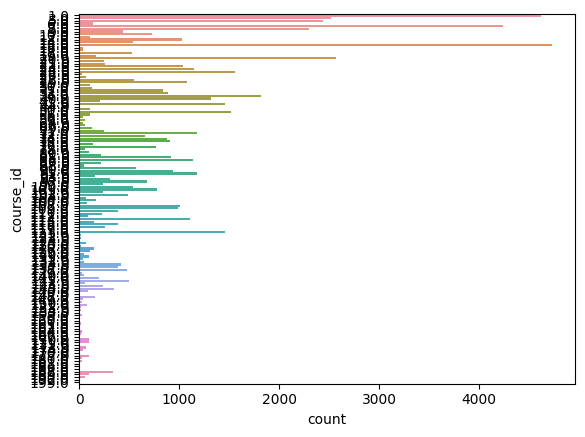

In [33]:
sns.countplot(y='course_id', data=df_user_course)

## 2.1 Повторяющиеся строки в `user_course` для одного пользователя и одного курса
(Варианты: запись в группу ?)

In [34]:
df_user_course['course_id'].value_counts()

course_id
15.0     4724
1.0      4616
7.0      4242
20.0     2568
3.0      2516
         ... 
199.0       3
124.0       3
162.0       3
186.0       2
187.0       1
Name: count, Length: 138, dtype: int64

In [35]:
users_counts = df_user_course['user_id'].value_counts()

In [36]:
users_counts.head(10)

user_id
504.0      65
5020.0     62
14064.0    44
17896.0    43
29160.0    39
13708.0    32
27867.0    29
44796.0    28
82890.0    27
13135.0    25
Name: count, dtype: int64

In [37]:
for k,v in users_counts.items():
    if v>=2:
        print(k,v)

504.0 65
5020.0 62
14064.0 44
17896.0 43
29160.0 39
13708.0 32
27867.0 29
44796.0 28
82890.0 27
13135.0 25
9289.0 24
3434.0 23
7673.0 23
38769.0 23
293.0 23
723.0 22
2785.0 22
6344.0 21
1456.0 21
1475.0 21
15333.0 21
26741.0 20
23481.0 19
974.0 19
43033.0 19
29740.0 19
6484.0 19
5028.0 19
18601.0 19
9439.0 18
20793.0 18
21994.0 18
3402.0 18
4200.0 18
9456.0 17
58349.0 17
188.0 17
8037.0 17
1894.0 17
4807.0 17
4271.0 17
64941.0 17
18509.0 16
18569.0 16
12492.0 16
36898.0 16
34821.0 16
31567.0 16
2653.0 16
16219.0 15
6169.0 15
23186.0 15
4573.0 15
29755.0 15
5040.0 15
12871.0 15
1302.0 15
35834.0 15
1977.0 15
3449.0 15
3116.0 15
18861.0 15
20774.0 15
6559.0 15
8111.0 15
2881.0 14
13148.0 14
4153.0 14
2819.0 14
57043.0 14
98740.0 14
2397.0 14
27462.0 14
115953.0 14
52569.0 13
18902.0 13
49579.0 13
23755.0 13
41944.0 13
7874.0 13
3731.0 13
245.0 13
21268.0 13
4560.0 13
40729.0 13
9495.0 13
11419.0 13
18966.0 13
32604.0 13
3399.0 13
8369.0 13
1785.0 12
6867.0 12
51085.0 12
49110.0 12
39551.

In [38]:
users_counts.index

Index([   504.0,   5020.0,  14064.0,  17896.0,  29160.0,  13708.0,  27867.0,
        44796.0,  82890.0,  13135.0,
       ...
        49231.0,  49235.0,  49124.0,  49259.0,  49272.0,  49270.0,  49268.0,
        49237.0,  48596.0, 128463.0],
      dtype='float64', name='user_id', length=45506)

In [39]:
uc_count = df_user_course[['user_id','course_id']].value_counts()

In [40]:
uc_count.head(20)

user_id  course_id
9257.0   13.0         6
64810.0  115.0        5
8185.0   13.0         4
691.0    1.0          4
13819.0  13.0         3
7582.0   5.0          3
1456.0   19.0         3
6584.0   1.0          3
30057.0  28.0         3
6559.0   1.0          3
29160.0  28.0         3
23611.0  3.0          3
1475.0   7.0          3
28472.0  13.0         3
5373.0   15.0         3
9178.0   18.0         3
4271.0   15.0         3
55342.0  15.0         2
55317.0  3.0          2
2209.0   1.0          2
Name: count, dtype: int64

Посмотрим на пользователя, у которого несколько записей с одиним и курсом и группой

In [41]:
user_params = ['user_id','course_id','group_id','paid','paid_month','full_paid','month_every_discount','created','project_work','mark','assessment_id','certificate_hash']

In [42]:
df_user_course.query("user_id==9257 and course_id==13")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
4412,9257.0,13.0,33.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13611.0,NaN
5436,9257.0,13.0,37.0,0.0,3.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13611.0,NaN
6611,9257.0,13.0,43.0,0.0,3.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13611.0,NaN
7424,9257.0,13.0,102.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13611.0,NaN
7503,9257.0,13.0,51.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13611.0,NaN
13100,9257.0,13.0,88.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,0.0,13611.0,NaN


In [43]:
df_user_course.query("user_id==64810 and course_id==115")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
32728,64810.0,115.0,NaN,0.0,0.0,0.0,0.0,2019-08-30 17:57:00,,0.0,51601.0,NaN
32729,64810.0,115.0,NaN,0.0,0.0,0.0,0.0,2019-08-30 18:00:00,,0.0,NaN,NaN
32730,64810.0,115.0,NaN,0.0,0.0,0.0,0.0,2019-08-30 18:01:00,,0.0,NaN,NaN
33104,64810.0,115.0,NaN,0.0,0.0,0.0,0.0,2019-09-04 19:55:00,,0.0,NaN,NaN
33105,64810.0,115.0,NaN,0.0,0.0,0.0,0.0,2019-09-04 19:57:00,,0.0,NaN,NaN


In [44]:
df_user_course.query("user_id==8185 and course_id==13")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
3751,8185.0,13.0,25.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13901.0,NaN
4389,8185.0,13.0,33.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13901.0,NaN
6616,8185.0,13.0,43.0,0.0,3.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13901.0,NaN
7693,8185.0,13.0,51.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,NaN,13901.0,NaN


In [45]:
df_user_course.query("user_id==691 and course_id==1")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
2830,691.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12133.0,NaN
4646,691.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12133.0,NaN
6524,691.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12133.0,NaN
6525,691.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12133.0,NaN


In [46]:
df_user_course.query("user_id==13819 and course_id==13")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
6582,13819.0,13.0,43.0,0.0,3.0,1.0,0.0,2018-10-10 14:15:00,,NaN,NaN,NaN
8644,13819.0,13.0,51.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,0.0,NaN,NaN
9718,13819.0,13.0,69.0,0.0,2.0,1.0,0.0,2018-10-10 14:15:00,,0.0,NaN,NaN


In [47]:
df_user_course.query("user_id==7582 and course_id==5")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
3454,7582.0,5.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,15691.0,NaN
6273,7582.0,5.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,15691.0,NaN
18781,7582.0,5.0,78.0,60000.0,5.0,1.0,0.0,2018-12-29 12:31:00,,0.0,15691.0,NaN


In [48]:
df_user_course.query("user_id==1456 and course_id==19")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
3845,1456.0,19.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,7439.0,NaN
3846,1456.0,19.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,7439.0,NaN
3847,1456.0,19.0,NaN,0.0,0.0,0.0,1000.0,2018-10-10 14:15:00,,NaN,7439.0,NaN


In [49]:
df_user_course.query("user_id==6584 and course_id==1")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
2851,6584.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,NaN,NaN
4575,6584.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,NaN,NaN
6528,6584.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,NaN,NaN


In [50]:
df_user_course.query("user_id==30057 and course_id==28")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
15834,30057.0,28.0,53.0,0.0,5.0,1.0,0.0,2018-10-16 15:17:00,,0.0,NaN,NaN
16904,30057.0,28.0,116.0,0.0,4.0,1.0,0.0,2018-11-13 11:13:00,,0.0,NaN,NaN
23705,30057.0,28.0,169.0,10.0,6.0,1.0,0.0,2019-04-30 13:26:00,,0.0,NaN,NaN


In [51]:
df_user_course.query("user_id==6559 and course_id==1")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
2831,6559.0,1.0,195.0,42000.0,5.0,1.0,1000.0,2018-10-10 14:15:00,,NaN,12478.0,NaN
5202,6559.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12478.0,NaN
6765,6559.0,1.0,NaN,0.0,0.0,0.0,0.0,2018-10-10 14:15:00,,NaN,12478.0,NaN


In [52]:
df_user_course.query("user_id==29160 and course_id==28")[user_params]

,user_id,course_id,group_id,paid,paid_month,full_paid,month_every_discount,created,project_work,mark,assessment_id,certificate_hash
16202,29160.0,28.0,116.0,0.0,5.0,1.0,0.0,2018-10-26 07:06:00,,0.0,NaN,NaN
32325,29160.0,28.0,170.0,10.0,5.0,1.0,0.0,2019-08-27 11:46:00,,0.0,NaN,NaN
50244,29160.0,28.0,395.0,10.0,1.0,0.0,0.0,2020-03-06 12:00:00,,0.0,NaN,NaN


In [53]:
# print(*df_user_course['certificate_hash'].unique(),sep='\n')

In [54]:
df_user_course['full_paid'].value_counts()

full_paid
0.0    58672
1.0     8137
Name: count, dtype: int64

In [55]:
sum(df_user_course['certificate_hash'].notna())

713

In [56]:
df_user_course[df_user_course['assessment_id'].notna()]

,user_id,course_id,paid,month_every_discount,full_paid,money_used,month_used,id,group_id,hidden_description,...,tax_deduction_pdf_hash,tax_deduction_pdf_path,tax_deduction_pdf_size,is_bundle,max_residual_discount,residual_discount,residual_percent_discount,show_project_work,show_sign,show_stamp
2,31.0,1.0,0.0,3500.0,0.0,0.0,0.0,31.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
5,55.0,1.0,0.0,3500.0,0.0,0.0,0.0,55.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
10,66.0,1.0,0.0,3500.0,0.0,0.0,0.0,66.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
13,72.0,1.0,0.0,3500.0,0.0,0.0,0.0,72.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
15,79.0,1.0,0.0,3500.0,0.0,0.0,0.0,79.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66807,128464.0,170.0,0.0,0.0,0.0,0.0,0.0,67669.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
66808,52592.0,108.0,0.0,0.0,0.0,0.0,0.0,67670.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
66809,128154.0,8.0,0.0,0.0,0.0,0.0,0.0,67671.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0
66810,128240.0,188.0,0.0,0.0,0.0,0.0,0.0,67672.0,NaN,,...,NaN,,NaN,0.0,0.3,0.0,0.0,0.0,1.0,1.0


In [57]:
sum(df_user_course['mark']>0.1)

151

In [58]:
sum(df_user_course['paid']>0.1)

8117

<Axes: >

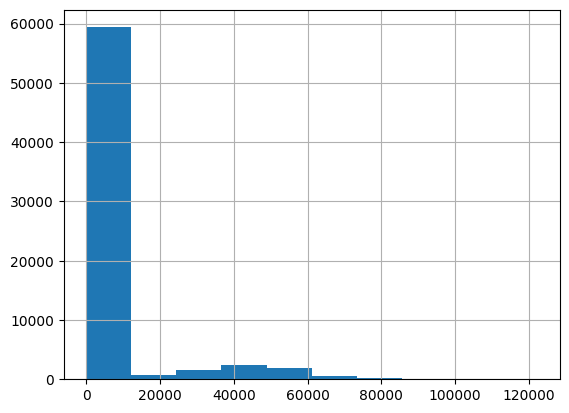

In [59]:
df_user_course['paid'].hist()

In [60]:
print(*df_user_course.columns,sep='\n')

user_id
course_id
paid
month_every_discount
full_paid
money_used
month_used
id
group_id
hidden_description
full_discount
promocode_id
paid_month
month_once_discount
mark
project_work
overdraft
certificate_hash
certificate_path
comment
control_date
reason_id
force_full_pay_flag
planned_date
assessment_reused
uid
certificate_path_en
project_work_latin
show_mark
partner_campaign_id
mode
max_month_discount
max_total_discount
company_id
step_discount
max_step_discount
step_percent_discount
hw_shift_date
created
assessment_id
is_hidden
loyalty_applied
welcome_applied
useronlinecourse_applied_id
tax_deduction_pdf_hash
tax_deduction_pdf_path
tax_deduction_pdf_size
is_bundle
max_residual_discount
residual_discount
residual_percent_discount
show_project_work
show_sign
show_stamp


<Axes: >

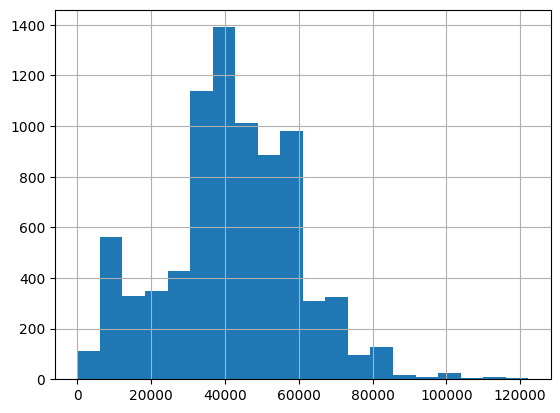

In [61]:
df_user_course[df_user_course['paid']>1]['paid'].hist(bins=20)

<Axes: >

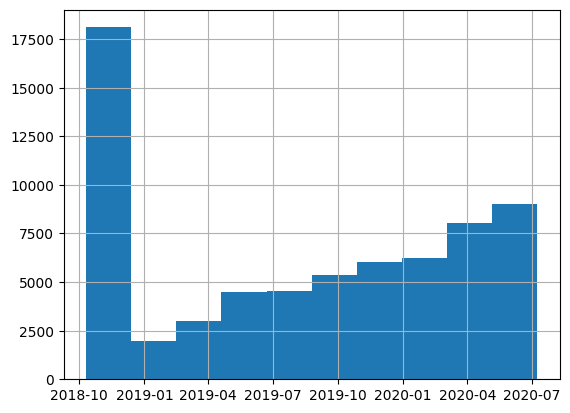

In [62]:
df_user_course['created'].hist()

## 2.2 Собираем таблицу пользователей и их "оценки"

In [63]:
def user_course_table():
    def get_rating(row):
        if row['certificate_hash']:
            return 100
        elif row['group_id']>0:
            return 60
        elif row['assessment_id'] > 0:
            return 30
        else:
            return 10
        
    # прочитать, только нужные столбцы из csv 
    ucols = ['user_id', 'course_id', 'created', 'certificate_hash', 'group_id', 'assessment_id']
    date_cols = ['created']
    int_cols = ['user_id', 'course_id', 'group_id', 'assessment_id']
    str_cols = ['certificate_hash']
    converters_uc  = {item:my_int_converter  for item in int_cols}
    converters_uc.update({item:my_date_converter  for item in date_cols})   
    converters_uc.update({item:str  for item in str_cols})
    
    data = pd.read_csv('../data/user_course.csv', usecols=ucols, sep=';', converters=converters_uc)
    data.sort_values(by='created')
    # условия для рейтинга:
    # есть диплом -> r = 1 (df_user_course['certificate_hash'].notna())
    # оплатил курс -> r += 0.4 (Хотя бы для одной из записей full_paid == 1 or group_id not None)
    # сдан вступительный тест -> r += 0.3 (Хотя бы для одной из записей assessment_id not NaN )
    # есть только запись в таблице, а больше ничего нет то ставим 0.1
    # Условия на 0 <= r <= 1
         
    data['rating'] = data.apply(get_rating, axis=1)
    data = data.drop(labels=['group_id', 'certificate_hash', 'assessment_id'], axis=1)
    data = data.dropna()
    data[['user_id', 'course_id']] = data[['user_id', 'course_id']].astype(int)
    
    
    # В data остались повторные записи, их надо почистить!
    return data

In [64]:
df = user_course_table()

In [65]:
df.head()

,user_id,course_id,created,rating
0,4,1,2018-10-10 14:15:00,10
1,27,1,2018-10-10 14:15:00,10
2,31,1,2018-10-10 14:15:00,30
3,48,1,2018-10-10 14:15:00,10
4,54,1,2018-10-10 14:15:00,10


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66788 entries, 0 to 66811
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    66788 non-null  int32         
 1   course_id  66788 non-null  int32         
 2   created    66788 non-null  datetime64[ns]
 3   rating     66788 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 2.0 MB


## 2.3 Удаляем дублирующие строчки

In [67]:
def drop_duplicates(df, ids, columns, ascending):
    """ Function delete duplicates in cols and leave min (ascending==1) or max (ascending==0) for unique values in ids

    Args:
        df (DataFrame): initial dataframe
        ids (list): columns names of user_id and product_id
        columns (list): list of columns names 
        ascending (list): list of bools values associated with columns

    Returns:
        DataFrame: 
    """       
    cols_iterator = enumerate(columns)
    i, col = next(cols_iterator)
    ndf = df.sort_values(col, ascending=ascending[i]).drop_duplicates(ids).set_index(ids)[[col]]
    for i, col in cols_iterator:        
        ndf[col] = df.sort_values(col, ascending=ascending[i]).drop_duplicates(ids).set_index(ids)[[col]]    
    return ndf.reset_index()

In [68]:
df = drop_duplicates(df, ['user_id','course_id'],['created','rating'],[1,0])

In [69]:
#df = df.reset_index()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65771 entries, 0 to 65770
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    65771 non-null  int32         
 1   course_id  65771 non-null  int32         
 2   created    65771 non-null  datetime64[ns]
 3   rating     65771 non-null  int64         
dtypes: datetime64[ns](1), int32(2), int64(1)
memory usage: 1.5 MB


Число уникальных пользователей

In [71]:
len(pd.unique(df['user_id']))

45494

Число уникальных курсов

In [72]:
len(pd.unique(df['course_id']))

138

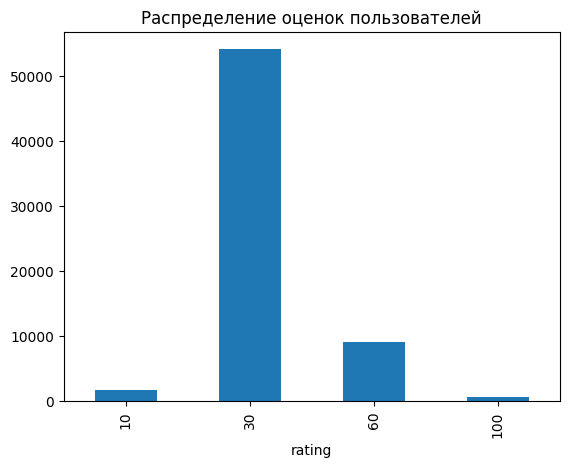

In [73]:
df.value_counts("rating", sort = False).plot(kind = 'bar', title='Распределение оценок пользователей');

Количество отсутствующих значений

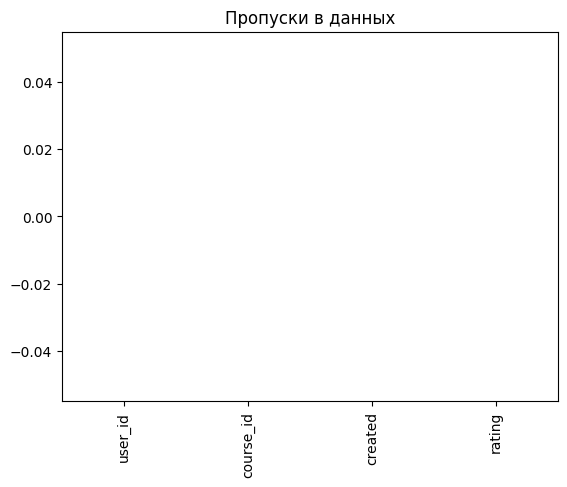

In [74]:
df.isna().sum().plot.bar(title="Пропуски в данных");

In [75]:
df[df['user_id']==8]

,user_id,course_id,created,rating
8549,8,17,2018-10-10 14:15:00,60
8899,8,19,2018-10-10 14:15:00,60
9777,8,1,2018-10-10 14:15:00,60
13882,8,10,2018-10-10 14:15:00,30
15901,8,13,2018-10-27 06:19:00,60
17066,8,28,2018-11-26 06:39:00,10


In [76]:
df[['user_id','course_id']].groupby('user_id').count()

,course_id
user_id,
4,2
8,6
27,1
29,1
31,2
...,...
128454,1
128455,1
128459,1


<Axes: xlabel='course_id', ylabel='count'>

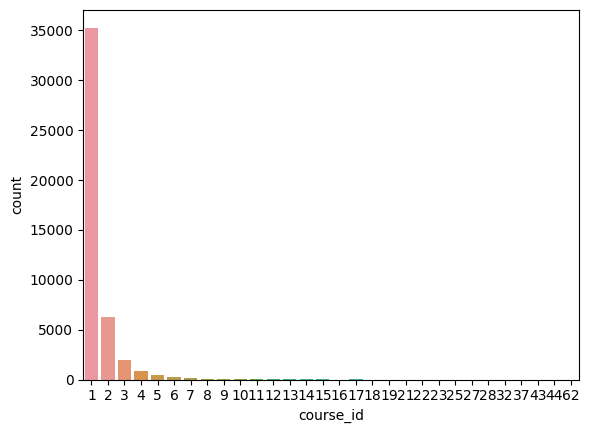

In [77]:
sns.countplot(x=df.groupby('user_id')['course_id'].count())

## 2.4 Разбиение данных 

In [78]:
def train_test_split(X, ratio=0.3, user_col='user_id', item_col='course_id',
                     rating_col='rating', time_col='created'):
    # сортируем оценки по времени
    X.sort_values(by=[time_col], inplace=True)
    # список всех юзеров
    userIds = X[user_col].unique()
    X_train_data = []
    X_test_data = []
    y_train = []
    y_test = []
    for userId in tqdm(userIds):
        curUser = X[X[user_col] == userId]
        # определяем позицию, по которой делим выборку и размещаем данные по массивам
        if curUser.shape[0] == 1:
            continue
        idx = int(curUser.shape[0] * (1 - ratio))
        X_train_data.append(curUser[[user_col, item_col]].iloc[:idx, :].values)
        X_test_data.append(curUser[[user_col, item_col]].iloc[idx:, :].values)
        y_train.append(curUser[rating_col].values[:idx])
        y_test.append(curUser[rating_col].values[idx:])
    # cтекуем данные по каждому пользователю в общие массивы
    X_train = pd.DataFrame(np.vstack(X_train_data), columns=[user_col, item_col])
    X_test = pd.DataFrame(np.vstack(X_test_data), columns=[user_col, item_col])
    y_train = np.hstack(y_train)
    y_test = np.hstack(y_test)
    return X_train, X_test, y_train, y_test

In [79]:
X_train, X_test, y_train, y_test = train_test_split(df)

  0%|          | 0/45494 [00:00<?, ?it/s]

In [80]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((17430, 2), 17430, (13066, 2), 13066)

Вопрос, так что означает запись в таблице?

In [81]:
X_train.head()

,user_id,course_id
0,4,1
1,662,1
2,662,18
3,680,1
4,667,1


# 3 Рассмотрим User-based model

In [82]:
class UserBased(BaseEstimator):
    def fit(self, X, y, user_col='user_id', item_col='course_id'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку пользователя
        X['y'] -= X[user_col].apply(lambda x: self.mean_y_user[x])
        
        # создаём векторы для каждого пользователя из набора использованных товаров
        # для неизвестных товаров ставим оценку 0
        self.user_ratings = pd.pivot_table(X, values='y', index=user_col,
                                           columns=item_col, fill_value=0)
        
        # считаем попарную схожесть между пользователями
        self.user_sim = cosine_similarity(self.user_ratings)
        
        # также сделаем словарь - {значение user_col: index в user_ratings = 1 значение (не вектор)}
        self.user_pos = dict()
        for user in self.users:
            self.user_pos[user] = np.argwhere(self.user_ratings.index.values == user)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
                
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict_rating_avg(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            if pr_user in self.users:
                return self.mean_y_user[pr_user]
            elif pr_item in self.items:
                return self.mean_y_item[pr_item]
            else:
                return 0
                
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.user_sim[self.user_pos[pr_user]].dot(
                        self.user_ratings.loc[:, pr_item])   
        # вычитаем 1, так как схожесть пользователя с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.user_sim[self.user_pos[pr_user]]).sum() - 1
        
        return self.mean_y_user[pr_user] + numerator / denominator
    
    def predict(self, X, user_col='user_id', item_col='course_id'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y
    
    def predict_avg(self, X, user_col='user_id', item_col='course_id'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating_avg(row[0], row[1]), axis=1)
        return y

In [83]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [84]:
results = []

In [85]:
%%time
print('start fitting...')
ub = UserBased().fit(X_train, y_train)
y_ub_pred = ub.predict(X_test)
y_ub_pred_avg = ub.predict_avg(X_test)
print('start predicting...')
print('rmse = {}'.format(rmse(y_test, y_ub_pred)))
print('for avg+ rmse = {}'.format(rmse(y_test, y_ub_pred_avg)))

start fitting...
start predicting...
rmse = 15.490190077640047
for avg+ rmse = 15.182974037547824
CPU times: total: 5.39 s
Wall time: 4.73 s


In [86]:
errors={'User-based model':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ub_pred),
        "Mean absolute error":mean_absolute_error(y_test, y_ub_pred),
        "Mean squared error":mean_squared_error(y_test, y_ub_pred,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ub_pred,squared=False),
        "R2": r2_score(y_test, y_ub_pred)
        }}
results.append(errors)
errors={'User-based model avg+':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ub_pred_avg),
        "Mean absolute error":mean_absolute_error(y_test, y_ub_pred_avg),
        "Mean squared error":mean_squared_error(y_test, y_ub_pred_avg,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ub_pred_avg,squared=False),
        "R2": r2_score(y_test, y_ub_pred_avg)
        }}
results.append(errors)

# 4 Рассмотрим Item-based model

In [87]:
class ItemBased(BaseEstimator):
    def fit(self, X, y, user_col='user_id', item_col='course_id'):
        X = X.copy()
        # сохраним текущих пользователей и имеющиеся предметы
        self.users = X[user_col].unique()
        self.items = X[item_col].unique()
        
        X['y'] = y
        # рассчитаем среднее значение рейтинга для пользователя и предмета
        self.mean_y_user = X.groupby(user_col)['y'].mean()
        self.mean_y_item = X.groupby(item_col)['y'].mean()
        
        # вычитаем среднюю оценку предмета
        X['y'] -= X[item_col].apply(lambda x: self.mean_y_item[x])
        
        # создаём векторы для каждого предмета с оценками пользователя
        # если пользователь не поставил оценку, то ставим 0
        self.item_ratings = pd.pivot_table(X, values='y', index=item_col,
                                           columns=user_col, fill_value=0)
        
        # считаем попарную схожесть между фильмами
        self.item_sim = cosine_similarity(self.item_ratings)
        
        # также сделаем словарь {значение item_col: index в item_ratings}
        self.item_pos = dict()
        for item in self.items:
            self.item_pos[item] = np.argwhere(self.item_ratings.index.values == item)[0][0]
        return self
    
    def predict_rating(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict_rating_avg(self, pr_user, pr_item):
        # если в обучающей выборке нет такого предмета
        # или пользователя, то вернём 0
        if not pr_item in self.items or not pr_user in self.users:
            if pr_user in self.users:
                return self.mean_y_user[pr_user]
            elif pr_item in self.items:
                return self.mean_y_item[pr_item]
            else:
                return 0
        
        # считаем числитель и знаменатель дроби из формулы предсказания
        numerator = self.item_sim[self.item_pos[pr_item]].dot(
                        self.item_ratings.loc[:, pr_user])   
        # вычитаем 1, так как схожесть предмета с самим собой равна 1,
        # но модель не должна это учитывать
        denominator = np.abs(self.item_sim[self.item_pos[pr_item]]).sum() - 1
        
        return self.mean_y_item[pr_item] + numerator / denominator
    
    def predict(self, X, user_col='user_id', item_col='course_id'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating(row[0], row[1]), axis=1)
        return y
    
    def predict_avg(self, X, user_col='user_id', item_col='course_id'):
        y = X[[user_col, item_col]].apply(lambda row: self.predict_rating_avg(row[0], row[1]), axis=1)
        return y

In [88]:
%%time
print('start fitting...')
ib = ItemBased().fit(X_train, y_train)
print('start predicting...')
y_ib_pred = ib.predict(X_test)
y_ib_pred_avg = ib.predict_avg(X_test)
print('rmse = {}'.format(rmse(y_test, y_ib_pred)))
print('for avg+ rmse = {}'.format(rmse(y_test, y_ib_pred_avg)))

start fitting...
start predicting...
rmse = 12.28521097835471
for avg+ rmse = 11.895508428231231
CPU times: total: 2.64 s
Wall time: 2.64 s


In [89]:
errors={'Item-based model':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ib_pred),
        "Mean absolute error":mean_absolute_error(y_test, y_ib_pred),
        "Mean squared error":mean_squared_error(y_test, y_ib_pred,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ib_pred,squared=False),
        "R2": r2_score(y_test, y_ib_pred)
        }}
results.append(errors)
errors={'Item-based model avg+':{
        "Mean absolute percentage error": mean_absolute_percentage_error(y_test, y_ib_pred_avg),
        "Mean absolute error":mean_absolute_error(y_test, y_ib_pred_avg),
        "Mean squared error":mean_squared_error(y_test, y_ib_pred_avg,squared=True),
        "Root mean squared error":mean_squared_error(y_test, y_ib_pred_avg,squared=False),
        "R2": r2_score(y_test, y_ib_pred_avg)
        }}
results.append(errors)

# 5 Сравнение рекомендаций моделей 

In [90]:
otputdf = pd.DataFrame.from_dict(results[0], orient= 'index')
for item in results[1:]:
    otputdf = pd.concat([otputdf, pd.DataFrame.from_dict(item, orient= 'index')],axis=0)
# otputdf = otputdf.drop('R2',axis=1)
otputdf.columns = ['MAPE','MAE','MSE','RMSE','R2']
otputdf

,MAPE,MAE,MSE,RMSE,R2
User-based model,0.294964,8.091467,239.945989,15.490190,-0.406881
User-based model avg+,0.292937,7.962230,230.522701,15.182974,-0.351629
Item-based model,0.281485,8.467896,150.926409,12.285211,0.115070
Item-based model avg+,0.279458,8.338659,141.503121,11.895508,0.170321


сравнить с самыми популярными курсами

In [91]:
X_train[X_train['user_id']==680]

,user_id,course_id
3,680,1


In [92]:
X_test.head()

,user_id,course_id
0,4,8
1,662,34
2,662,108
3,680,34
4,667,92


In [93]:
y_test[:5]

array([30, 30, 30, 60, 30], dtype=int64)

In [94]:
df[df['user_id']==680]

,user_id,course_id,created,rating
10113,680,1,2018-10-10 14:15:00,30
34725,680,34,2019-10-04 16:02:00,60


In [95]:
df_course[df_course['id']==1]['title']

0    Разработчик Java
Name: title, dtype: object

In [96]:
df_course[df_course['id']==34]['title']

33    Разработчик на Spring Framework
Name: title, dtype: object

In [97]:
df_with_title = df.merge(df_course[['id','title']], left_on='course_id', right_on='id')

In [98]:
df_with_title[df_with_title['user_id']==667]

,user_id,course_id,created,rating,id,title
6,667,1,2018-10-10 14:15:00,30,1.0,Разработчик Java
30651,667,92,2020-05-28 09:40:00,30,92.0,Android-разработчик. Базовый курс
45025,667,91,2020-03-12 09:29:00,30,91.0,Android-разработчик. Продвинутый курс


In [99]:
X_test.iloc[3:4]

,user_id,course_id
3,680,34


In [100]:
print(f'user-based {ub.predict(X_test.iloc[3:4])}')
print(f'user-based {ub.predict_avg(X_test.iloc[3:4])}')
print(f'user-based {ib.predict(X_test.iloc[3:4])}')
print(f'user-based {ib.predict_avg(X_test.iloc[3:4])}')
y_test[3]

user-based 3    30.0
dtype: float64
user-based 3    30.0
dtype: float64
user-based 3    40.38047
dtype: float64
user-based 3    40.38047
dtype: float64


60

In [101]:
df_with_title.groupby(['course_id','title'])[['course_id','title']]

# 6. Сохраним словарик с названиями курсов

In [ ]:
print(

In [ ]:
df_course = df_course.astype({'id':'int'})
res = df_course[['id','title']].set_index('id').to_dict()
res['title']
from recosys.models.serialize import store
store(res['title'], 'course_names')

# 7. Сохраняем модель 

### Вариант названия работы: 

- Рекомендательная система online курсов на основе коллаборативной фильтрации